## Skorch SA network classification
tpham328

Source: https://github.com/jlm429/pyperch/blob/master/notebooks

In [5]:
import subprocess

# Installation on Google Colab
!git clone https://github.com/jlm429/pyperch
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/pyperch')

try:
    import google.colab
    subprocess.run(['python', '-m', 'pip', 'install', 'skorch' , 'torch'])
except ImportError:
    pass

fatal: destination path 'pyperch' already exists and is not an empty directory.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
import torch
from torch import nn
from skorch import NeuralNetClassifier
from skorch import NeuralNet
from pyperch.neural.sa_nn import SAModule
from pyperch.utils.decorators import add_to
from skorch.dataset import unpack_data
import copy
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve


In [7]:
print(torch.cuda.is_available())

True


In [8]:
data = pd.read_csv("winequality-white.csv")
print("Successfully Imported Data!")

data.head()
print(data.shape)

Successfully Imported Data!
(4898, 12)


In [9]:
from sklearn.model_selection import train_test_split

X = data.drop(columns = 'quality')

original_Y = data['quality']
def class_quality(value):
    if value <= 5:
        return 0
    elif value == 6:
        return 1
    elif value >= 7:
        return 2

Y = original_Y.apply(class_quality)


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)


Y.value_counts(0)

quality
1    2198
0    1640
2    1060
Name: count, dtype: int64

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=328)
print(Y_train.value_counts(0))
print(Y_test.value_counts(0))

quality
1    1748
0    1336
2     834
Name: count, dtype: int64
quality
1    450
0    304
2    226
Name: count, dtype: int64


In [11]:
Y_train = Y_train if isinstance(Y_train, np.ndarray) else Y_train.to_numpy()
Y_test = Y_test if isinstance(Y_test, np.ndarray) else Y_test.to_numpy()

# Convert to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.long)

In [12]:
from skorch.callbacks import EpochScoring

net = NeuralNetClassifier(
    module=SAModule,
    module__input_dim=11,
    module__output_dim=3,
    module__hidden_units=200,
    module__hidden_layers=2,
    module__step_size=.1,
    module__t=20000,
    module__cooling=.99,
    max_epochs=5000,
    verbose=0,
    callbacks=[EpochScoring(scoring='accuracy', name='train_acc', on_train=True),],
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
    device = 'cuda',
)

## train_step_single override - add SA training step and disable backprop

In [13]:
SAModule.register_sa_training_step()

In [14]:
# fit data
net.fit(X_train, Y_train)

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=SAModule(
    (dropout): Dropout(p=0, inplace=False)
    (activation): ReLU()
    (output_activation): Softmax(dim=-1)
    (layers): ModuleList(
      (0): Linear(in_features=11, out_features=200, bias=True)
      (1-2): 2 x Linear(in_features=200, out_features=200, bias=True)
      (3): Linear(in_features=200, out_features=3, bias=True)
    )
  ),
)

## Plot learning curves

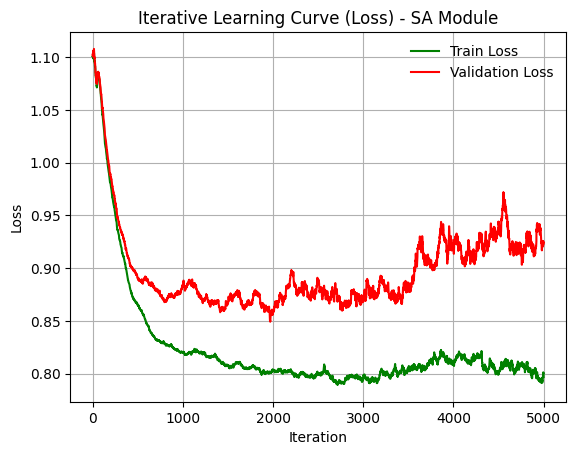

In [15]:
# plot the iterative learning curve (loss)
plt.plot(net.history[:, 'train_loss'], label='Train Loss', color='green')
plt.plot(net.history[:, 'valid_loss'], label='Validation Loss', color='red')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Iterative Learning Curve (Loss) - SA Module")
plt.grid(visible=True)
plt.legend(frameon=False)

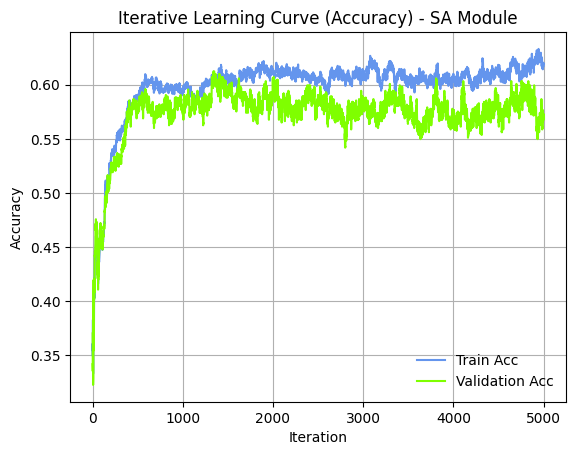

In [16]:
# plot the iterative learning curve (accuracy)
plt.plot(net.history[:, 'train_acc'], label='Train Acc', color='cornflowerblue')
plt.plot(net.history[:, 'valid_acc'], label='Validation Acc', color='chartreuse')
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Iterative Learning Curve (Accuracy) - SA Module")
plt.grid(visible=True)
plt.legend(frameon=False)

## Using sklearn learning curve with RO

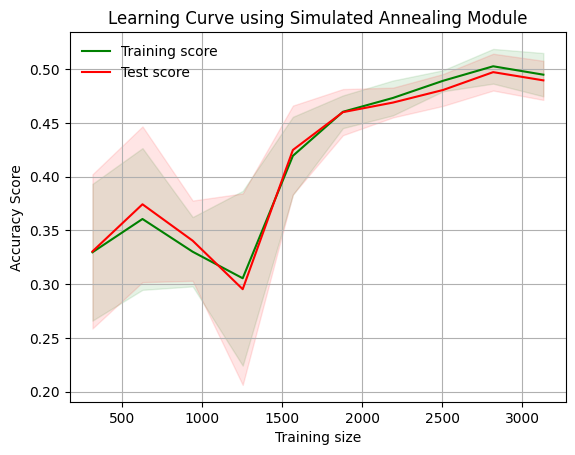

In [17]:

net = NeuralNetClassifier(
    module=SAModule,
    module__input_dim=11,
    module__output_dim=3,
    module__hidden_units=200,
    module__hidden_layers=2,
    module__step_size=.1,
    module__t=20000,
    module__cooling=.99,
    max_epochs=200,
    verbose=0,
    callbacks=[EpochScoring(scoring='accuracy', name='train_acc', on_train=True),],
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
    device = 'cuda',
)

# Plot the learning curve
train_sizes, train_scores, test_scores = learning_curve(
    net, X_train, Y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=5
)

train_scores_mean = train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
test_scores_mean = test_scores.mean(axis=1)
test_scores_std = test_scores.std(axis=1)
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color='green')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color='red')
plt.plot(train_sizes, train_scores_mean, label="Training score", color='green')
plt.plot(train_sizes, test_scores_mean, label="Test score", color='red')
plt.title("Learning Curve using Simulated Annealing Module")
plt.xlabel("Training size")
plt.ylabel("Accuracy Score")
plt.grid(visible=True)
plt.legend(frameon=False)

## Using sklearn grid search with RO

In [18]:
from sklearn.model_selection import GridSearchCV

# deactivate skorch-internal train-valid split and verbose logging
net.set_params(train_split=False, verbose=0, )

# module specific parameters need to begin with 'module__'
default_params = {
    'module__input_dim': [11],
    'module__output_dim': [3],
    'module__step_size': [0.1],
    'module__t': [5000],
}

grid_search_params = {
    'module__cooling': [0.99, 0.999],
    'max_epochs': [50, 100, 200],
    'module__hidden_units': [100, 200],
    'module__hidden_layers': [1, 2],
    **default_params,
}

gs = GridSearchCV(net, grid_search_params, refit=False, cv=3, scoring='accuracy', verbose=2)

gs.fit(X_train, Y_train)
print("best score: {:.3f}, best params: {}".format(gs.best_score_, gs.best_params_))

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] END max_epochs=50, module__cooling=0.99, module__hidden_layers=1, module__hidden_units=100, module__input_dim=11, module__output_dim=3, module__step_size=0.1, module__t=5000; total time=   4.4s
[CV] END max_epochs=50, module__cooling=0.99, module__hidden_layers=1, module__hidden_units=100, module__input_dim=11, module__output_dim=3, module__step_size=0.1, module__t=5000; total time=   4.3s
[CV] END max_epochs=50, module__cooling=0.99, module__hidden_layers=1, module__hidden_units=100, module__input_dim=11, module__output_dim=3, module__step_size=0.1, module__t=5000; total time=   4.3s
[CV] END max_epochs=50, module__cooling=0.99, module__hidden_layers=1, module__hidden_units=200, module__input_dim=11, module__output_dim=3, module__step_size=0.1, module__t=5000; total time=   4.7s
[CV] END max_epochs=50, module__cooling=0.99, module__hidden_layers=1, module__hidden_units=200, module__input_dim=11, module__output_dim=3, mo

In [19]:
X_test = torch.tensor(X_test, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.long)

In [20]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

net.fit(X_train,Y_train)

# Predict on test data
Y_pred = net.predict(X_test)

# Compute accuracy
accuracy = accuracy_score(Y_test, Y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Compute F1 score for each class
f1 = f1_score(Y_test, Y_pred, average=None)
print(f'F1 Score (per class): {f1}')

# Compute and print the classification report
report = classification_report(Y_test, Y_pred, target_names=['low', 'medium', 'high'])
print(report)

Accuracy: 0.5224
F1 Score (per class): [0.58387097 0.59425494 0.        ]
              precision    recall  f1-score   support

         low       0.57      0.60      0.58       304
      medium       0.50      0.74      0.59       450
        high       0.00      0.00      0.00       226

    accuracy                           0.52       980
   macro avg       0.36      0.44      0.39       980
weighted avg       0.41      0.52      0.45       980



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
